The aim of this kernel is to detect hate speech  in tweets.

In [1]:
import os

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import nltk
from wordcloud import WordCloud,STOPWORDS
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.pipeline import make_pipeline

import warnings 
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv(r"C:\Users\subhi\OneDrive\Desktop\dataset\finaltrain.csv")
test = pd.read_csv(r"C:\Users\subhi\OneDrive\Desktop\dataset\test.csv")
train.sample(2)

,Unnamed: 0,id,label,tweet,clean_tweet,#
22123,22123,22124,0,"we didn't know then, of course, that this woul...","we didn't know then, of course, that this woul...",NaN
13930,13930,13931,0,"wow, kay!! glad to have you along! any reque...","wow, kay!! glad to have you along! any request...",#inthemoog


In [4]:
train.shape, test.shape

((31962, 6), (17197, 2))

In [5]:
df = train.append(test, ignore_index = True)
df.shape

(49159, 6)

Remove twitter handlers i.e., @user

In [6]:
train['cleaned_tweet'] =train.tweet.apply(lambda x: ' '.join([word for word in x.split() if not word.startswith('@')]))
test['cleaned_tweet'] =test.tweet.apply(lambda x: ' '.join([word for word in x.split() if not word.startswith('@')]))

### Hashtags

In [7]:
#Select all words from normal tweet
normal_words = ' '.join([word for word in train['cleaned_tweet'][train['label'] == 0]])
#Collect all hashtags
pos_htag = [htag for htag in normal_words.split() if htag.startswith('#')]
#Remove hashtag symbol (#)
pos_htag = [pos_htag[i][1:] for i in range(len(pos_htag))]
#Count frequency of each word
pos_htag_freqcount = nltk.FreqDist(pos_htag)
pos_htag_df = pd.DataFrame({'Hashtag' : list(pos_htag_freqcount.keys()),
                            'Count' : list(pos_htag_freqcount.values())})

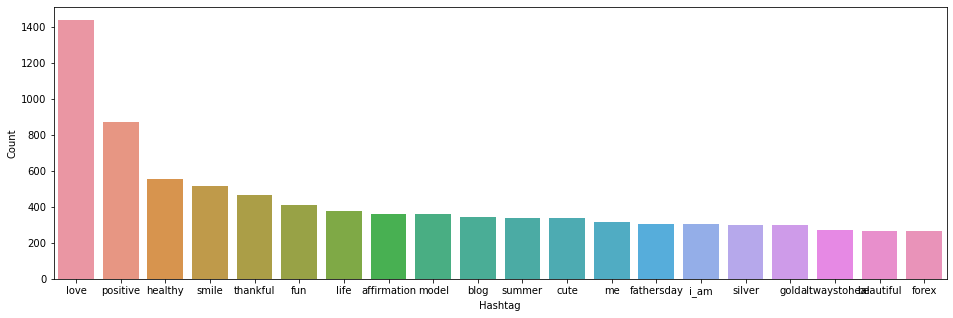

In [8]:
#Select top 20 most frequent hashtags and plot them   
most_frequent = pos_htag_df.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=most_frequent, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

In [9]:
#Repeat same steps for negative tweets
negative_words = ' '.join([word for word in train['cleaned_tweet'][train['label'] == 1]])
neg_htag = [htag for htag in negative_words.split() if htag.startswith('#')]
neg_htag = [neg_htag[i][1:] for i in range(len(neg_htag))]
neg_htag_freqcount = nltk.FreqDist(neg_htag)
neg_htag_df = pd.DataFrame({'Hashtag' : list(neg_htag_freqcount.keys()),
                            'Count' : list(neg_htag_freqcount.values())})

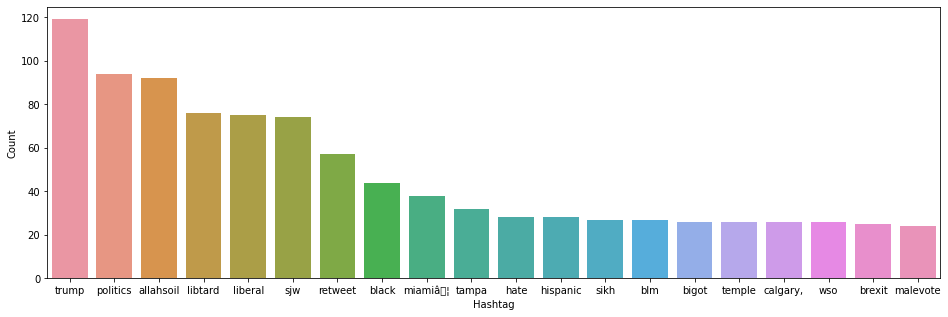

In [10]:
most_frequent = neg_htag_df.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5))
ax = sns.barplot(data=most_frequent, x= "Hashtag", y = "Count")
plt.show()

From both plots, we can conclude that hashtags are very important for sentiment analysis and should not be ignored.

## Finding common words in both classes of tweets using Visualization

### Normal Tweets

Normal words


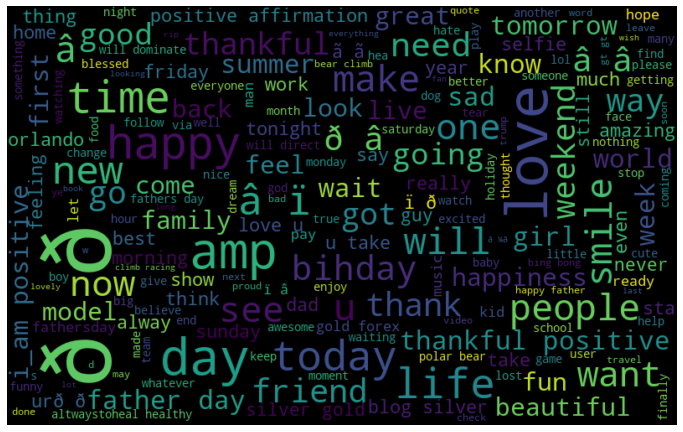

In [11]:
normal_words = ' '.join([word for word in train['cleaned_tweet'][train['label'] == 0]])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110).generate(normal_words)
print('Normal words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

### Negative Tweets

Negative words


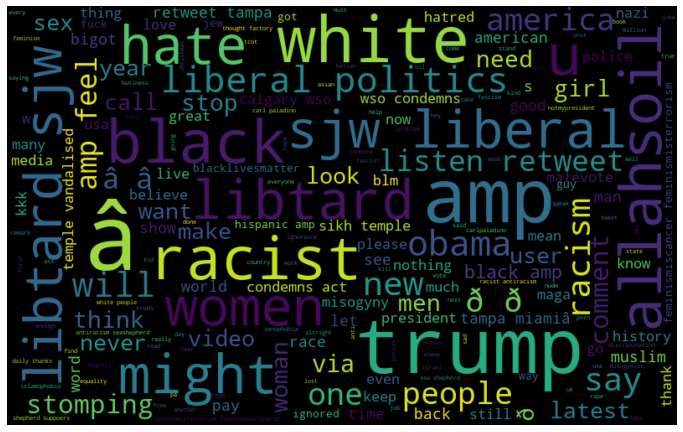

In [12]:
negative_words = ' '.join([word for word in train['cleaned_tweet'][train['label'] == 1]])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110).generate(negative_words)
print('Negative words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

Words used like love, friend, happy are used in normal tweets whereas racist/sexist can be found in words like trump, black, politics etc.

In [13]:
train.sample(2)

,Unnamed: 0,id,label,tweet,clean_tweet,#,cleaned_tweet
24408,24408,24409,0,@user belles customised trunki and bits came t...,"belles customised trunki and bits came today, ...",#cute,"belles customised trunki and bits came today, ..."
12377,12377,12378,0,why's taylor mccaw a cow ?? pls help she is tr...,why's taylor mccaw a cow ?? pls help she is tr...,#upset #upthebum,why's taylor mccaw a cow ?? pls help she is tr...


In [14]:
X_train, X_val, y_train, y_val = train_test_split(train['cleaned_tweet'], train['label'], random_state = 0)
X_train.shape, X_val.shape

((23971,), (7991,))

## Applying Bag-of-Words

Rescale data using CountVectorizer
### CountVectorizer

In [15]:
vect = CountVectorizer().fit(X_train)
vect

CountVectorizer()

In [16]:
print('Total features =', len(vect.get_feature_names()))
print(vect.get_feature_names()[::5000])

Total features = 34478
['00', 'btg', 'encouragement', 'ifcarlingdidperfectdays', 'mona', 'rdoequipment', 'technology']


In [17]:
X_train_vectorized = vect.transform(X_train)
X_train_vectorized

<23971x34478 sparse matrix of type '<class 'numpy.int64'>'
	with 266363 stored elements in Compressed Sparse Row format>

### Logistic Regression

In [18]:
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
pred = model.predict(vect.transform(X_val))
print('F1 :', f1_score(y_val, pred))

F1 : 0.6441860465116279


TDIDF

In [19]:
# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 5
vect = TfidfVectorizer().fit(X_train)
print('Total Features =', len(vect.get_feature_names()))
X_train_vectorized = vect.transform(X_train)

model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
pred = model.predict(vect.transform(X_val))
print('F1: ', f1_score(y_val, pred))

Total Features = 34478
F1:  0.41907514450867056


## Bag-of-Words with more than one word (n-grams)

### min_df & n-grams

In [20]:
vect = CountVectorizer(min_df = 2, ngram_range = (1,2)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
print('Total Features =', len(vect.get_feature_names()))

model = LogisticRegression()
model.fit(X_train_vectorized, y_train)
pred = model.predict(vect.transform(X_val))
print('F1: ', f1_score(y_val, pred))

Total Features = 38957
F1:  0.6409356725146199


### Hyper parameter tuning

In [21]:
vect = CountVectorizer(min_df = 1, ngram_range = (1,1)).fit(X_train)
X_train_vectorized = vect.transform(X_train)
print('Total Features =', len(vect.get_feature_names()))

model = LogisticRegression(C = 10)
model.fit(X_train_vectorized, y_train)
pred = model.predict(vect.transform(X_val))
print('F1: ', f1_score(y_val, pred))

Total Features = 34478
F1:  0.6811751904243744


In [22]:
print('Fraction of negative tweet in train data :', train.label.sum()/len(train))
print('Fraction of negative tweet predicted by model :', pred.sum()/len(pred))

Fraction of negative tweet in train data : 0.07014579813528565
Fraction of negative tweet predicted by model : 0.04855462395194594


Fraction is very less. Lets change the default predict probability.

In [23]:
pred_prob = model.predict_proba(vect.transform(X_val))
pred = np.where(pred_prob[:,1] > 0.35, 1, 0)
print('Fraction of negative tweet predicted by model :', sum(pred)/len(pred))
print('F1: ', f1_score(y_val, pred))

Fraction of negative tweet predicted by model : 0.055437367037917656
F1:  0.6960985626283367


Using hyperparameter tuning and probability method, we were able to improve our model score by 5%.

Lets look at largest and smallest coefficients that our model used.

In [24]:
feature_names = np.array(vect.get_feature_names())
sorted_coef_index = model.coef_[0].argsort()
print('Smallest_coefs :\n{}\n'.format(feature_names[sorted_coef_index[:10]]))
print('Largest_coefs :\n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest_coefs :
['mommas' 'hardcore' 'dating' 'bihday' 'orlando' 'healthy' 'day'
 'miscegenation' 'hack' 'rightly']

Largest_coefs :
['allahsoil' 'bigot' 'inauguration' 'fakenews' 'spit' 'equality'
 'blacklivesmatter' 'brazilians' 'misogynist' 'malevote']


The smallest coefficients are indicating to normal tweets to the model whereas the largest coeeficients are indicative for racist/sexist tweets.

In [25]:
X_test = test['tweet']
test_pred = model.predict_proba(vect.transform(X_test))
predictions = np.where(test_pred[:,1] > 0.35, 1, 0)
results = pd.DataFrame(data = {'id' : test.id, 'label' : predictions})
results.to_csv(r"C:\Users\subhi\OneDrive\Desktop\dataset\trainresult.csv")